# Astropy Smorgasbord

## Table of Contents

1. [Astropy](#Astropy)  
      1.1 [Tables](#Tables)  
      1.2 [Cosmology](#Cosmology)  
2. [Photometry with Photutils](#Photometry-with-Photutils)  
3. [Astroquery](#Astroquery)  
      3.1 [NED query](#NED-query)  
      3.2 [Gaia query](#Gaia-query)  
      3.3 [IRSA query of 2MASS](#IRSA-query-of-2MASS)  
      3.4 [SDSS query](#SDSS-query)  
      3.5 [Skyview](#Skyview)  
4. [Resources](#Resources)

# Astropy

Astropy is a the python package designed to contain the basic utilities needed for astronomy.  It has been many years in the making and replicated some of the functionaily of other astronomy packages from IRAF and IDL.  However, it still is missing many packages and utilities needed for say reduction, handling spectra, etc. As it is a community driven effort, its unclear how it will take for additional functionality to be included.

## Tables

Data tables are convenient way of dealing with large data sets, particularly if you need to create, read, modifiy and/or write files (i.e. ASCII, FITS, HDF5, etc...).  Both Pandas and Astropy have their own unique support of data tables and it is possible to convert back and forth betweeen them.  The question arises why are there two different types of data table formats and what are the benifits of using one over the other. 
 
Pandas strengths are within its statistical machinary available for data analysis. Whereas the Astropy table has a few astronomy specific advantages; 1) being able to work with astronomy formats (i.e. FITS, sextractor, CDS, VOTables, etc) and 2) being able to use units within the table.  It may becomes necessary to switch back and forth between tables depending on the task at hand.  

Here we will give you a very brief introduction to Astropy tables.

First you need to load the following modules in order to utilize an Astropy table.

In [11]:
from astropy.table import QTable
import astropy.units as u
import numpy as np

Here we will create a QTable which is a quantity table.  The first column is the redshift of the source, the second is the star formation rate (SFR), the third is the stellar mass and the fourth is the rotational velocity. Since it is a QTable, we can define the units for each of the entries, if we like.

In [ ]:
a = [0.10, 0.15, 0.2]
b = [10.0, 2.0,  100.0] * u.M_sun / u.yr
c = [1e10, 1e9,  1e11]  * u.M_sun
d = [150., 100., 2000.] * u.km / u.s

When we create the table, we can assign the names to each column

In [ ]:
t = QTable([a, b, c, d],
           names=('redshift', 'sfr', 'stellar_mass', 'velocity'))

We can display the table by typing the variable into the notebook

In [ ]:
t

We can display the information about the table (i.e. data type, units, name)

In [ ]:
t.info

We can view a specific column by calling is name.

In [ ]:
t['sfr']

We can also group subsets of columns.

In [ ]:
t['sfr','velocity']

We can call a specific row, in this case the first row, which shows all the entries for the first object.  Remember python indexing starts with zero!

In [ ]:
t[0]

We can write to a standard format if we like, binary FITS tables are often used for this. If could be an ASCII file (either sapace, tab or comma delimited) or whatever your favorite sharable file format is.  There is a whole [list](https://docs.astropy.org/en/stable/io/unified.html#table-io) of supported formats that can be read in, many astronomy specific.

In [ ]:
t.write('my_table.fits', overwrite=True) 

You can read it in just as easily too. As you can see, the units are stored as well, as long as you are using a QTable.

In [ ]:
all_targets = QTable.read("my_table.fits")

In [ ]:
all_targets

We can add new entries to the table.  In this case specific star formation rate (sSFR).

In [ ]:
t['ssfr'] = t['sfr'] / t['stellar_mass']

In [ ]:
t

Maybe we are unhappy using years and we want to convert to Gyr. There are a whole list of available units [here](https://docs.astropy.org/en/stable/units/).

In [ ]:
t['ssfr'].to(1./u.gigayear)

If we want to estimate the H-alpha line lunminosity from the SFR using an emperical relation (such as one from Kennicutt et al. 1998).

In [ ]:
t['lum'] = (t['sfr'] * u.erg / u.s )/(7.9e-42 * u.Msun / u.yr)

In [ ]:
t

Say we want to go from erg to photons, which are both "energy".  You can see it is not quite as straight forward by the follwoing error.

In [ ]:
(t['lum']).to(u.ph / u.s)

In order to convert to photons/s properly, we need to check the units. Our beginning and ending units match (i.e. energy/time), we just need to acount for the energy of the photon which is depends on the wavelength.

$$ E_{phot} = \frac{h c}{\lambda} $$

(1) As an exercise for the reader. Modify the above table to estimate the number of photons/s from the H-alpha line luminosity the energy of the photon instead.

## Cosmology

[top](#Table-of-Contents)

If your working with measurements involving redshift or various (age, structure, etc) parameters of the Universe, you will want to use a cosmology calculator. Astropy comes with one which could make it easier to do the calculations yourself instead of trying to look up the values (i.e http://www.astro.ucla.edu/~wright/CosmoCalc.html)

A very helpful reference in understanding these comological quanties can be found in the [Hogg 1999](https://arxiv.org/abs/astro-ph/9905116) paper


Let first import the cosmology module and see what the value of H$_{0}$.

In [1]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.H(0)

<Quantity 69.32 km / (Mpc s)>

If we want to use the most recent Planck results we can use that.  You can pick your favorite result and import that.

In [2]:
from astropy.cosmology import Planck18 as cosmo  # Planck 2018
cosmo.H(0)

<Quantity 67.66 km / (Mpc s)>

If you want to modify your own cosmology, you can import one.  Here is one where it has flat curvature with cold dark matter universe.

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

There are lot of useful functions in the cosmology class that you might encounter in everyday research. A lot of the them for the Friedmann-Lemaitre-Robertson-Walker comology are listed here: https://docs.astropy.org/en/stable/api/astropy.cosmology.FLRW.html

Here are a few common ones:

(1) Luminosity distance - distance used in calculating from an observer to the object

In [18]:
cosmo.luminosity_distance(4) 

<Quantity 35842.35296334 Mpc>

(2) Angular diameter distance - the distance between onjects on the sky (this is different than the luminosity difference)

In [5]:
cosmo.angular_diameter_distance(2)

<Quantity 1726.33748003 Mpc>

(3) The age of the universe at redshift z

In [6]:
cosmo.age(0) 

<Quantity 13.4617013 Gyr>

(4) The redshift at a specific age of the universe

In [12]:
from astropy.cosmology import z_at_value

z_at_value(cosmo.age, 2 * u.Gyr) 

3.1456706042370572

(5) The time ellapsed between the observer and the object at redshift z

In [8]:
cosmo.lookback_time(2) 

<Quantity 10.23901965 Gyr>

(6) The critical density of the universe at redshift z

In [9]:
cosmo.critical_density(0)

<Quantity 9.20387392e-30 g / cm3>

For flux (flux density) calculations it is very important to calculate the luminosity distance ($D_{l}$) to an object.

$$ F = \frac{L}{4\pi D_{l}^{2}} $$

Without going too much into cosmology, flux density is slightly different and you should be extra careful.  For more information about the comoslogy relations see the [Hogg 1999](https://arxiv.org/abs/astro-ph/9905116) paper.

$$ F_{\nu} = \frac{L_{\nu}}{4\pi D_{l}^{2}(1+z)} $$


Text(0, 0.5, 'lumonisty distance Dl [Mpc]')

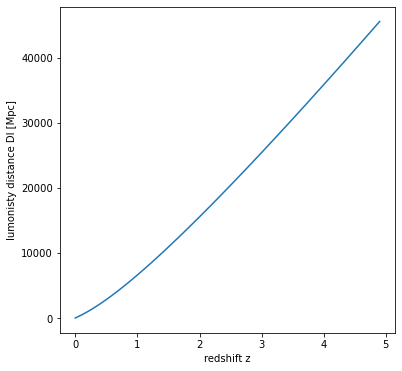

In [20]:
zs = np.arange(0,5,0.1)
Dl = cosmo.luminosity_distance(zs) 

fig = plt.figure(figsize=(6,6))
p = fig.add_subplot(111)
p.plot(zs,Dl)
p.set_xlabel("redshift z")
p.set_ylabel("lumonisty distance Dl [Mpc]")

(1) As an excerise for the reader, reproduce Figure 2 from the [Hogg 1999](https://arxiv.org/abs/astro-ph/9905116)  paper using the Astropy cosmology package 

(2) As an *advanced* excerise for the reader, reproduce Figure 5 from the [Hogg 1999](https://arxiv.org/abs/astro-ph/9905116) paper using the Astropy cosmology package. 

# Photometry with Photutils

[top](#Table-of-Contents)

What is photometry?  It is the measurement of light from a source, either represented as flux or magnitude. There are several ways to compute the flux from a source. In this tutorial we will go over aperture photometry, where you draw a circular region around the source and measure the flux inside.

[Photoutils](https://photutils.readthedocs.io) is a useful astropy package for performing photometry.  This includes but not limited to aperture photometry, PSF photometry, star finding, source isophotes, background subtraction, etc...

Large parts of this tutorial are borrowed from [Getting Started with Photutils](https://photutils.readthedocs.io/en/stable/getting_started.html) documentation.

Here we load in a star field image provided with Photutils.  We are interested in a small subsection of the image in which we want to do photometry.

In [ ]:
import numpy as np
from photutils import datasets

hdu = datasets.load_star_image()  
image = hdu.data[500:700, 500:700].astype(float)
head = hdu.header

The type function is useful for determining what data type you are dealing with, especially if it is an unfamilar one.

In [ ]:
print(type(hdu))
print(type(image))
print(type(head))

Assuming your background is uniform (and it most certianly is not), here is a rough background subtraction. 

This may not work for all astronomical fields (e.g. clusters, low surface brightness features, etc). There are more sophisticated ways to deal with the background subtraction, see the [Background Estimation](https://photutils.readthedocs.io/en/stable/background.html) documentation.

In [ ]:
image -= np.median(image) 

We use [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) to find all of the objects in the image. 

The FWHM (Full Width Half Maximum) is a way of measureing the size of the source. Often for unresolved sources, like stars, the FWHM should be matched the resolution of the telescope (or the seeing).  

The threshold is the value above the background in which the star finding algorithm will find sources. Often this should be done in a statistical sense in which a real detection is n-sigma above the background (or n standard deviations). We can measure the standard deviation of background. 

Statistics aside:
Assuming a Gaussian distribution for the noise, 1-sigma contains 68% of the distribution, 2-sigma contains 95% of the distribution and 3-sigma contains 99.7% of the distribution. Often 5-sigma is the golden standard in physics and astronomy for a "real" detection as it is contains 99.99994% background distribution.  

Here we use 3-sigma (3 standard devations) above the background for a "real" detection. 

In [ ]:
from photutils import DAOStarFinder
from astropy.stats import mad_std

bkg_sigma = mad_std(image)

daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)  
sources = daofind(image)

for col in sources.colnames: sources[col].info.format = '%.8g'  # for consistent table output
print(sources[:10])
print(sources.info)

In [ ]:
from photutils import aperture_photometry, CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=4.)  
phot_table = aperture_photometry(image, apertures)

for col in phot_table.colnames: phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table[:10])
print(phot_table.info)

Here we use the Matplotlib routine imshow to display the image.  The apertures.plot command is a routine specific to Photutils. We will see later how to plot tables of data...

In [14]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray_r', origin='lower')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

NameError: name 'image' is not defined

In [ ]:
print(head.keys())

# Astroquery

[top](#Table-of-Contents)

Astroquery is a Astropy package for querying astronomical databases.  There many, many, many  catalogs and image services.  Astroquery can be used to find catalogs and images.  In this tutorial, we will show a few different databases and and ways to search for data.

## NED query

NED is the [NASA/IPAC Extragalacitc Database](https://ned.ipac.caltech.edu/).  It can be useful for finding measurements, properties and papers about
your favorite galaxy (or galaxies).  Like many databases you can search for galaxies via their name or coordinates.

First we need to import the modules that we will use for this tutorial.

In [ ]:
from astroquery.ned import Ned
from astropy import coordinates
import astropy.units as u

In [ ]:
result_table = Ned.query_object("m82")
print(result_table)

Print the columns returned from the search.

In [ ]:
print(result_table.keys())

Print the redshift of the source

In [ ]:
print(result_table['Redshift'])

Lets now search for objects around M82.

In [ ]:
result_table = Ned.query_region("m82", radius=1 * u.arcmin)
print(result_table)

## Gaia query
[top](#Table-of-Contents)

[Gaia](https://sci.esa.int/web/gaia) is a space observatory designed to observe the precise positions of stars in order to determine their distances and motions within the galaxy.  Gaia star coordinates are the new golden standard for astrometry.  Being able to querry their database to correct your catalogs and images to their coordinate system would be highly beneficial. 

In [ ]:
from astroquery.gaia import Gaia

In [ ]:
coord = coordinates.SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(1.0, u.arcmin)
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()

r.pprint()
print(r.keys())

## IRSA query of 2MASS
[top](#Table-of-Contents)

IRSA is the [NASA/IPAC Infrared Science Archive](https://irsa.ipac.caltech.edu).  IRSA typically has a infrared mission focus, such as 2MASS, Herschel, Planck, Spitzer, WISE, etc...

In [ ]:
from astroquery.irsa import Irsa

In [ ]:
Irsa.list_catalogs()

In [ ]:
table = Irsa.query_region("m82", catalog="fp_psc", spatial="Cone",radius=10 * u.arcmin)

In [ ]:
table

In [ ]:
table.keys()

## SDSS query

[top](#Table-of-Contents)

[SDSS](https://www.sdss.org/) or the Sloan Digital Sky Survey is a massive survey of the sky which originally was optical imaging and spectroscopy.  It has been operating for over 20 years and the well beyond the original planned survey as it has expanded to near-infrared observations of stars and IFUs (integral field units) for observing galaxies and eventually the whole sky LVM (Local Volume Mapper). It is an immense data set to draw from. 

In [ ]:
from astroquery.sdss import SDSS

Coordinates of your favorite object, in this case M82 in degrees.

In [ ]:
ra, dec = 148.969687, 69.679383

In [ ]:
co = coordinates.SkyCoord(ra=ra, dec=dec,unit=(u.deg, u.deg), frame='fk5')

In [ ]:
xid = SDSS.query_region(co, radius=10 * u.arcmin)
# print the first 10 entries
print(xid[:10])
print(xid.keys())

In [ ]:
print(xid['ra','dec'][:10]) # print the first 10 entries

## Skyview
[top](#Table-of-Contents)

[Skyview](https://skyview.gsfc.nasa.gov) is a virtual observatory that is connected to several surveys and imaging data sets spanning multiple wavelengths. It can be a handy way to get quick access to multi-wavelength imaging data for your favorite object.

In [ ]:
from astroquery.skyview import SkyView

SkyView.list_surveys()

In [ ]:
pflist = SkyView.get_images(position='M82', survey=['SDSSr'],radius=10 * u.arcmin)

In [ ]:
ext = 0
pf = pflist[0] # first element of the list, might need a loop if multiple images
m82_image = pf[ext].data

Plot image

In [ ]:
ax = plt.subplot()
ax.imshow(m82_image, cmap='gray_r', origin='lower', vmin=-10, vmax=20)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

Plot the in RA and Declination coordinates space, instead of pixels. The WCS (or World Coordinates System) in a FITS file has a set of keywords that define the coordinate system.  

Typical keywords are the following:

CRVAL1, CRVAL2 - RA and Declination (in degrees) coordinates of CRPIX1 and CRPIX2.

CRPIX1, CRPIX2 - Pixel positions of CRVAL1 and CRVAL2.

CDELT1, CDELT2 - pixel scale (or plate scale) in degrees/pixel 
(or CD matrix: CD1_1, CD1_2, CD2_1, CD2_2 which represent the pixel scale and rotation with respect to the position angle)

In [ ]:
from astropy.wcs import WCS

Use the FITS header to define the WCS of the image.

In [ ]:
head = pf[ext].header
wcs = WCS(head)

ax = plt.subplot(projection=wcs)
ax.imshow(m82_image, cmap='gray_r', origin='lower', vmin=-10, vmax=20)
#ax.grid(color='white', ls='solid')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

#ax.scatter(xid['ra'],xid['dec'],marker="o",s=50,transform=ax.get_transform('fk5'),edgecolor='b', facecolor='none')
#ax.set_xlim()
#ax.set_ylim()
ax.get_xlim()
ax.get_ylim()

# Resources

[top](#Table-of-Contents)

http://learn.astropy.org/tutorials.html - list of all the Astropy tutorials

https://docs.astropy.org/en/stable/wcs/ - Astropy WCS implementation

https://docs.astropy.org/en/stable/table/ - Astropy data tables

https://docs.astropy.org/en/stable/units/ - Astropy units

https://docs.astropy.org/en/stable/cosmology/ - Astropy cosmology

https://astroquery.readthedocs.io - astroquery documentation

https://photutils.readthedocs.io - photutils documentation